# Brain Atlas Analysis

Review ROI atlases from original BOLD5000 paper and from vcAtlas.

In [102]:
from pathlib import Path
from nilearn import image, plotting
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm.auto import tqdm

In [2]:
dataset_v1 = Path('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000')
dataset_v2 = Path('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000r2')

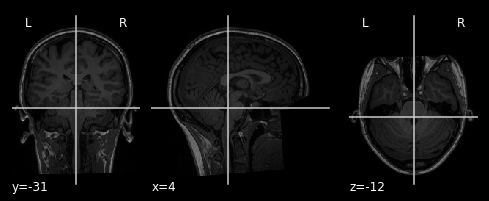

In [3]:
csi3_anat = image.load_img('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/BOLD5000_Structural/CSI3_Structural/T1w_MPRAGE_CSI3.nii')
plotting.plot_anat(csi3_anat)

## Load all ROIs into one Atlas

In [4]:
masks = sorted(list(dataset_v1.glob(f'**/sub-CSI3_mask-L*.nii.gz')))
masks

[PosixPath('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI3/sub-CSI3_mask-LHEarlyVis.nii.gz'),
 PosixPath('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI3/sub-CSI3_mask-LHLOC.nii.gz'),
 PosixPath('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI3/sub-CSI3_mask-LHOPA.nii.gz'),
 PosixPath('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI3/sub-CSI3_mask-LHPPA.nii.gz'),
 PosixPath('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI3/sub-CSI3_mask-LHRSC.nii.gz')]

In [59]:
atlas = None
for i, mask in enumerate(masks):
    roi = nib.load(mask).get_fdata()
    print(f'Mask:{mask.name} i:{i}')
    if atlas is None:
        atlas = roi
    else:
        collisions = np.count_nonzero(np.logical_and(roi, atlas))
        if collisions != 0:
            print(f'{collisions} collisions! i: {i}')
        # Change to use np.where
        atlas = np.where(atlas == 0, roi * (i + 1), atlas)

Mask:sub-CSI3_mask-LHEarlyVis.nii.gz i:0
Mask:sub-CSI3_mask-LHLOC.nii.gz i:1
12 collisions! i: 1
Mask:sub-CSI3_mask-LHOPA.nii.gz i:2
41 collisions! i: 2
Mask:sub-CSI3_mask-LHPPA.nii.gz i:3
Mask:sub-CSI3_mask-LHRSC.nii.gz i:4


In [60]:
atlas.shape

(72, 88, 67)

In [61]:
np.unique(atlas)

array([0., 1., 2., 3., 4., 5.])

In [62]:
np.count_nonzero(atlas == 6)

0

In [63]:
atlas_img = nib.Nifti1Image(atlas, nib.load(masks[0]).affine)

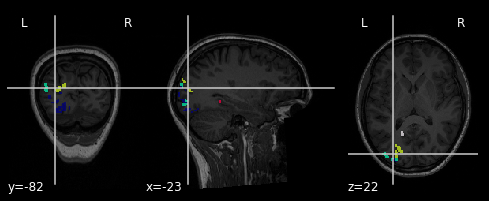

In [64]:
plotting.plot_roi(atlas_img, csi3_anat)

## CSI1 Atlas

In [90]:
csi1_anat = nib.load(dataset_v1 / 'BOLD5000_Structural/CSI1_Structural/T1w_MPRAGE_CSI1.nii')
csi1_masks = sorted(list(dataset_v1.glob(f'**/sub-CSI1_mask-L*.nii.gz')))
csi1_masks

[PosixPath('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI1/sub-CSI1_mask-LHEarlyVis.nii.gz'),
 PosixPath('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI1/sub-CSI1_mask-LHLOC.nii.gz'),
 PosixPath('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI1/sub-CSI1_mask-LHOPA.nii.gz'),
 PosixPath('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI1/sub-CSI1_mask-LHPPA.nii.gz'),
 PosixPath('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI1/sub-CSI1_mask-LHRSC.nii.gz')]

In [94]:
csi1_atlas = nib.load(csi1_masks[0]).get_fdata()
for label, mask in enumerate(csi1_masks[1:], start = 2):
    roi = nib.load(mask).get_fdata()
    collisions = np.count_nonzero(np.logical_and(roi, csi1_atlas))
    if collisions:
        print(f'WARNING: {collisions} collisions found for label {label}')
    # Change to use np.where
    csi1_atlas = np.where(csi1_atlas == 0, roi * label, csi1_atlas)

In [95]:
np.unique(csi1_atlas)

array([0., 1., 2., 3., 4., 5.])

In [46]:
csi1_atlas_img = nib.Nifti1Image(csi1_atlas, nib.load(csi1_masks[0]).affine)

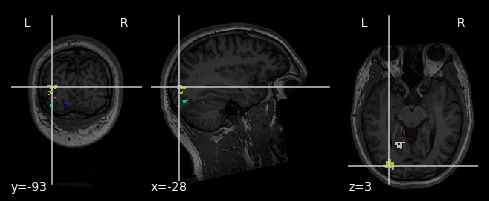

In [47]:
plotting.plot_roi(csi1_atlas_img, csi1_anat)

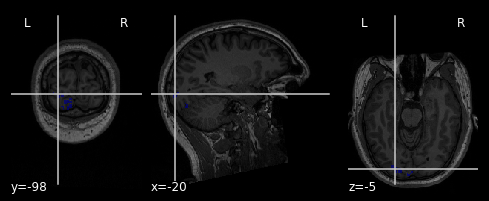

In [18]:
plotting.plot_roi(nib.load(csi1_masks[0]), csi1_anat)

### Compute LH and RH Atlases for Each Subject

In [134]:
# Subjects are selected from subdirectories of existing SPM derivatives
subjects = sorted([d for d in (dataset_v1 / 'derivatives' / 'spm').iterdir() if d.is_dir()])
# For now, atlases are divided into 
for subject in tqdm(subjects, desc='Subject'):
    for hemi in ['LH', 'RH']:
        # Find individual volumetric mask files
        masks = sorted(subject.glob(f'*mask-{hemi}*.nii.gz'))
        atlas = nib.load(masks[0]).get_fdata()
        for label, mask in enumerate(masks[1:], start=2):
            roi = nib.load(mask).get_fdata()
            # Due to broken ROIs, check for noninteger masks
            assert np.array_equal(np.unique(roi), [0, 1])
            # Switching to np.where
            # If there is overlap between ROIs, one ROI will overwrite the other
            atlas = np.where(atlas == 0, roi * label, atlas)
        # Due to broken ROIs, check for correct labels
        assert np.array_equal(np.unique(atlas), np.arange(0, len(masks) + 1))
        # Save atlas
        filename = subject / f'{subject.name}_atlas-{hemi}.nii.gz'
        nib.Nifti1Image(atlas, nib.load(masks[0]).affine).to_filename(filename)

Subject:   0%|          | 0/4 [00:00<?, ?it/s]

#### Check Atlas Output

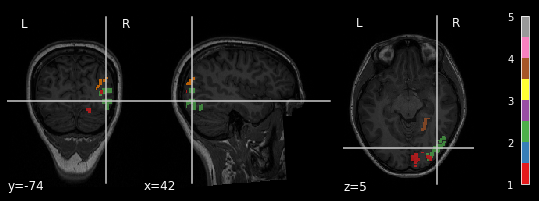

In [139]:
plotting.plot_roi(nib.load('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI3/sub-CSI3_atlas-RH.nii.gz'), 
                  bg_img=csi3_anat,
                  colorbar=True,
                  vmax=5,
                  cmap='Set1'
                 )

In [136]:
d = nib.load('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI3/sub-CSI3_atlas-RH.nii.gz').get_fdata()
np.unique(d)

array([0., 1., 2., 3., 4., 5.])


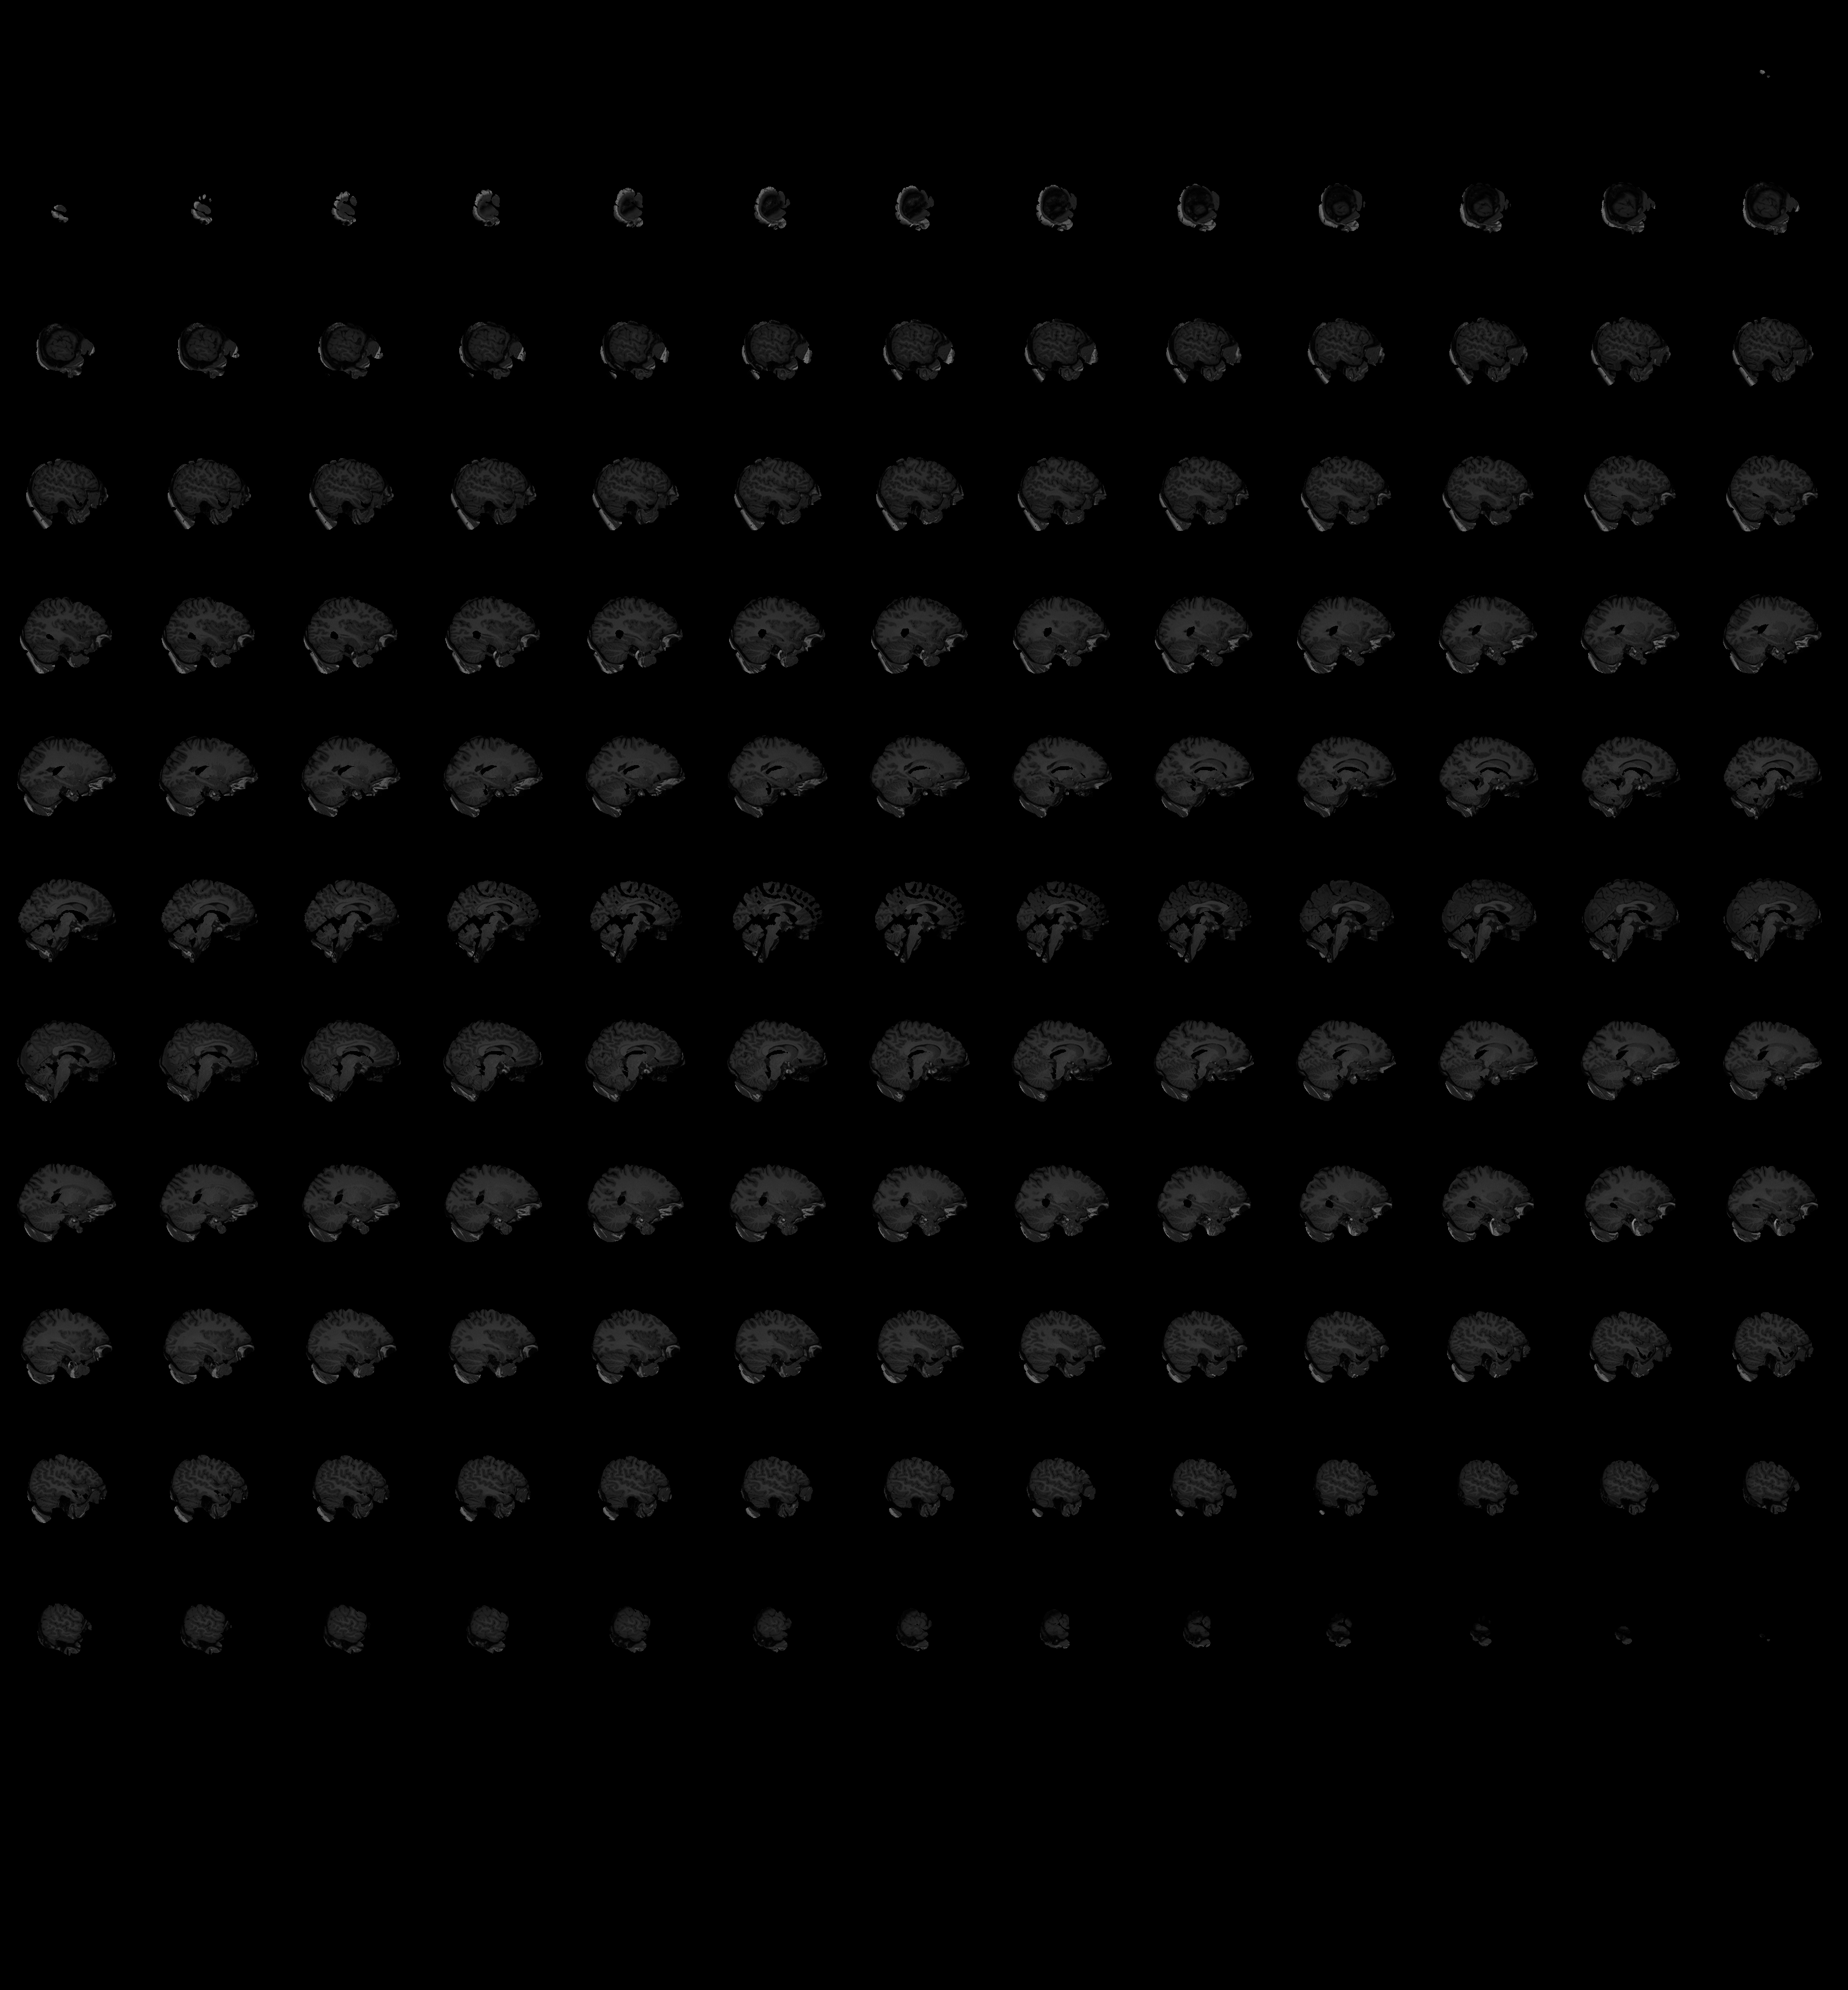
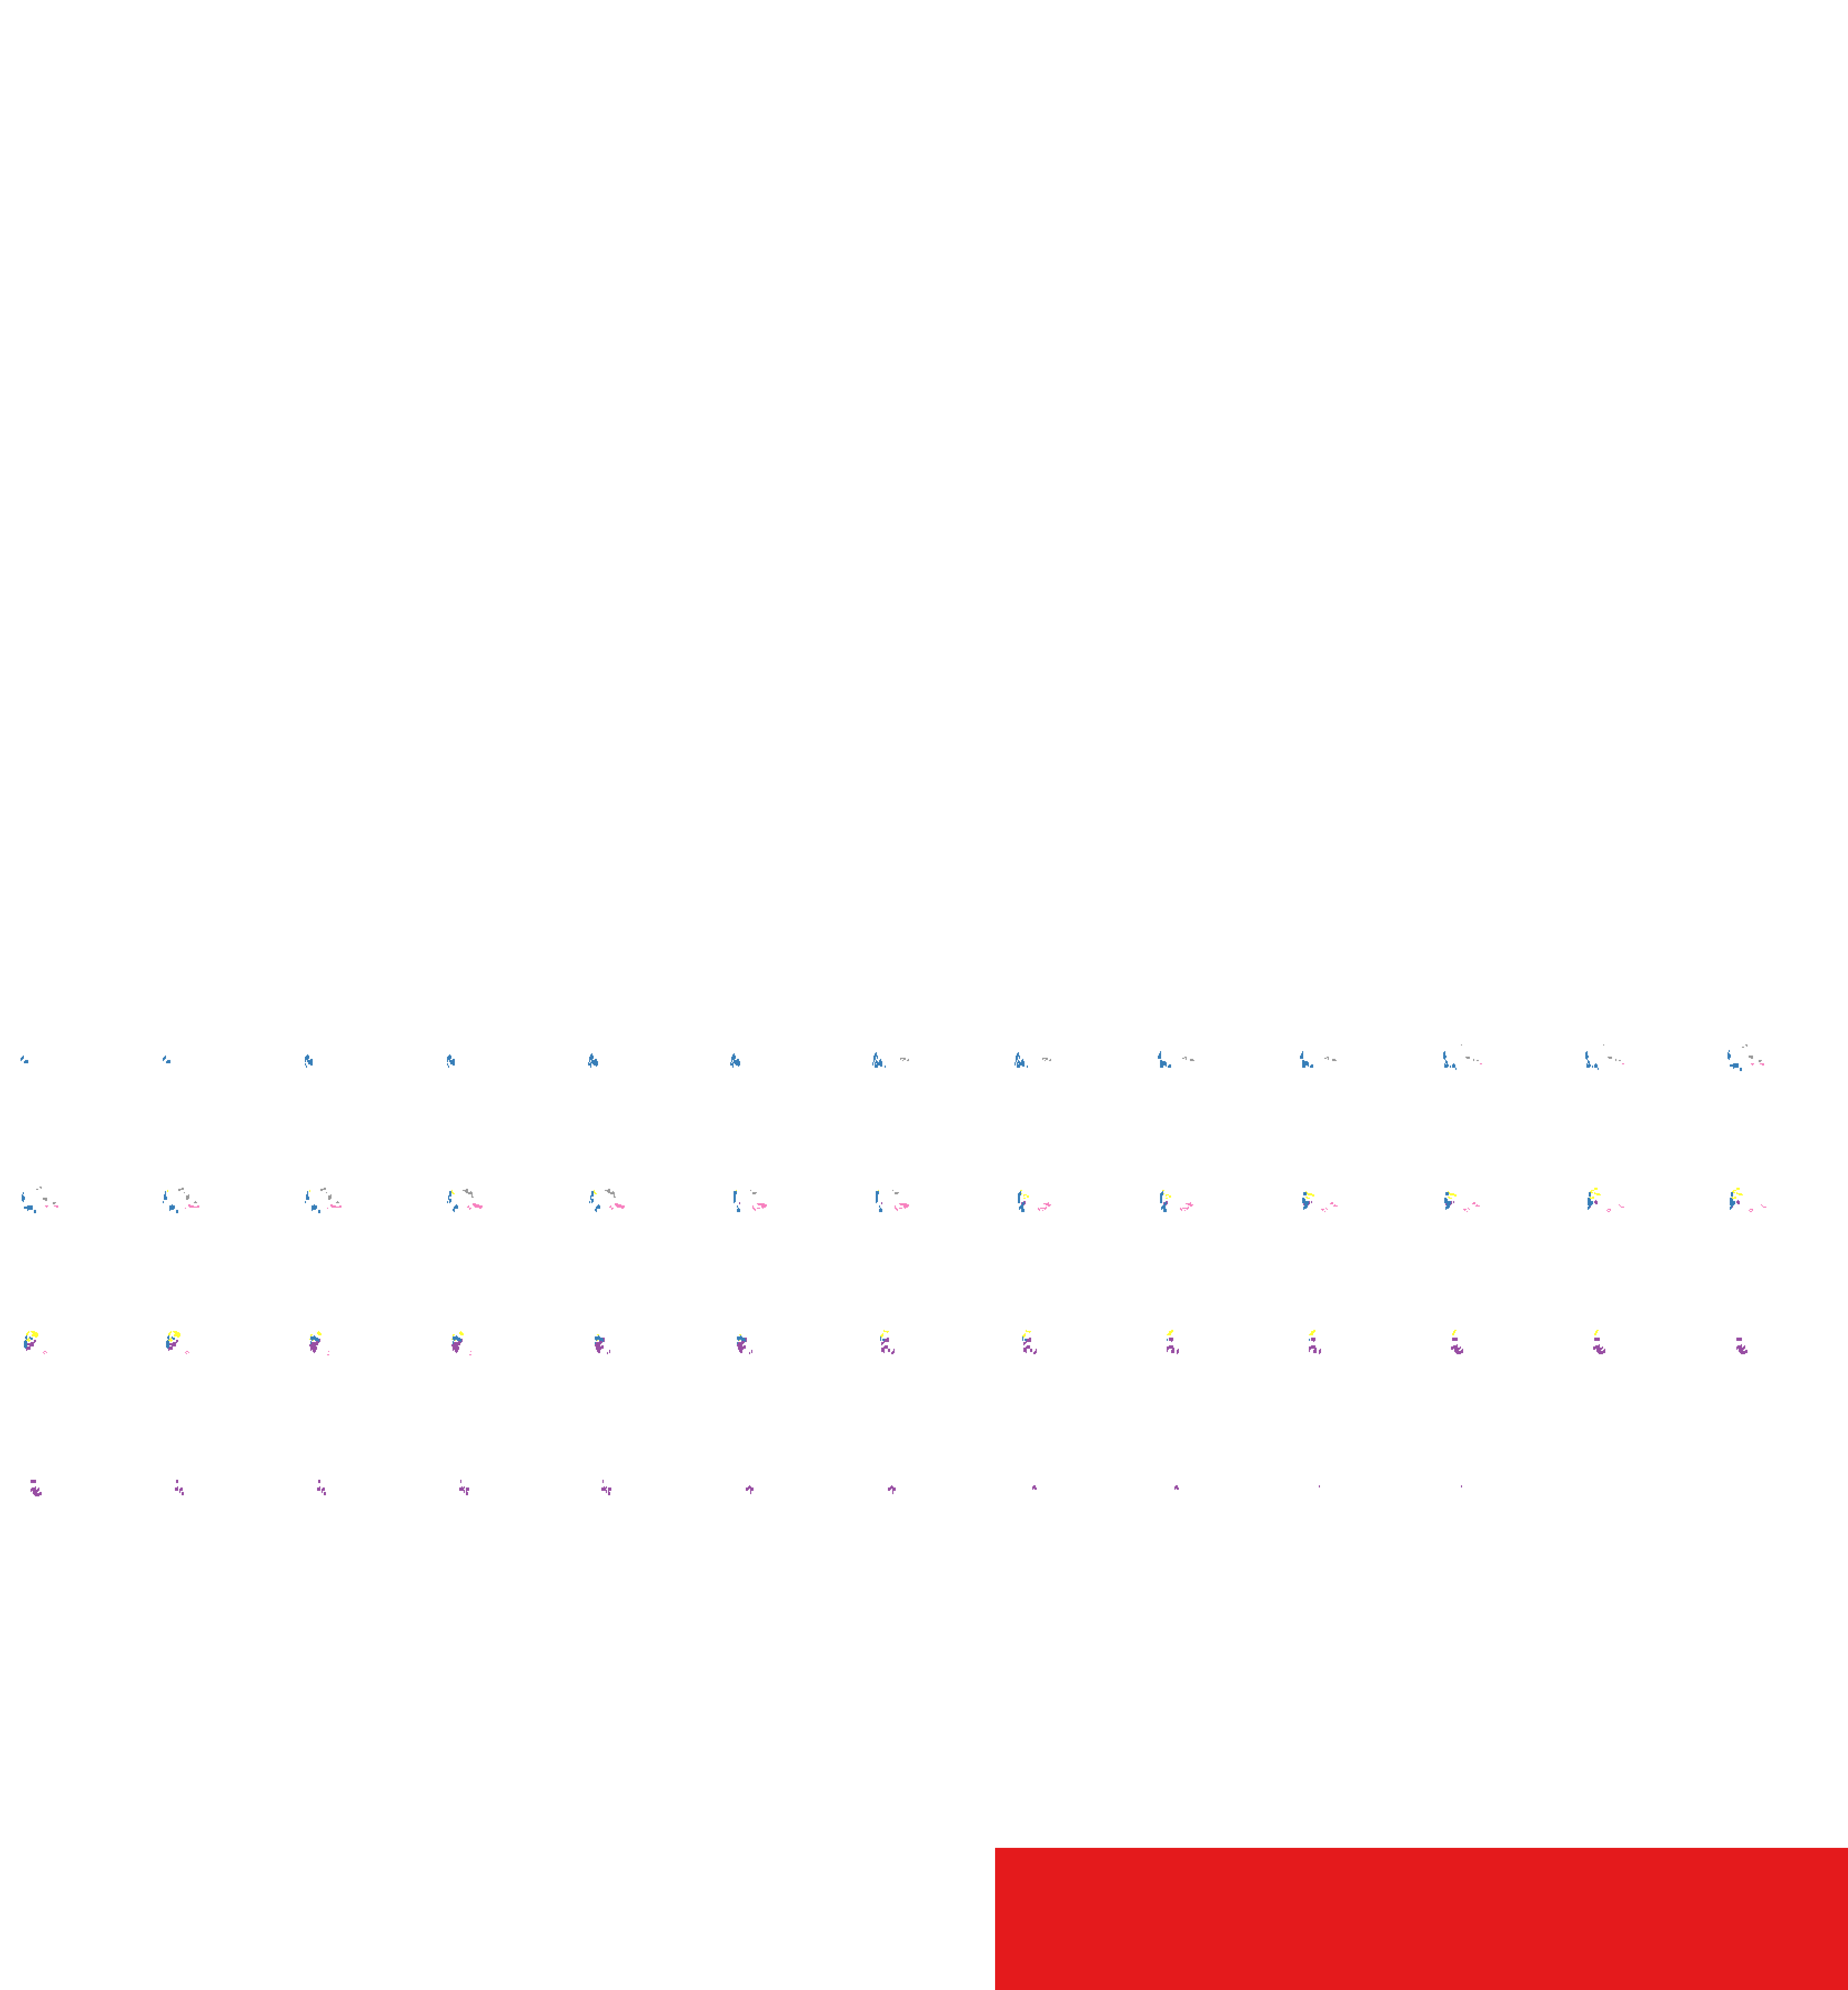

In [138]:
plotting.view_img(nib.load('/s/babbage/b/nobackup/nblancha/public-datasets/bold5000/derivatives/spm/sub-CSI3/sub-CSI3_atlas-RH.nii.gz'), 
                  bg_img=csi3_anat,
                  cmap='Set1',
                  symmetric_cmap=False,
                  resampling_interpolation='nearest'
                 )

## Combine Left and Right

In [66]:
comb_csi1_atlas = None
for i, mask in enumerate(csi1_masks[0:]):
    roi = nib.load(mask).get_fdata()
    rh_mask = re.sub(r'(?<=_mask-)L(?=H)', 'R', str(mask))
    roi += nib.load(rh_mask).get_fdata()
    if comb_csi1_atlas is None:
        comb_csi1_atlas = roi
    else:
        comb_csi1_atlas += roi * (i + 1)

In [69]:
np.unique(comb_csi1_atlas)

array([0., 1., 2., 3., 4., 5.])

In [67]:
comb_csi1_atlas_img = nib.Nifti1Image(comb_csi1_atlas, nib.load(csi1_masks[0]).affine)

In [76]:
csi1_affine = nib.load(csi1_masks[0]).affine

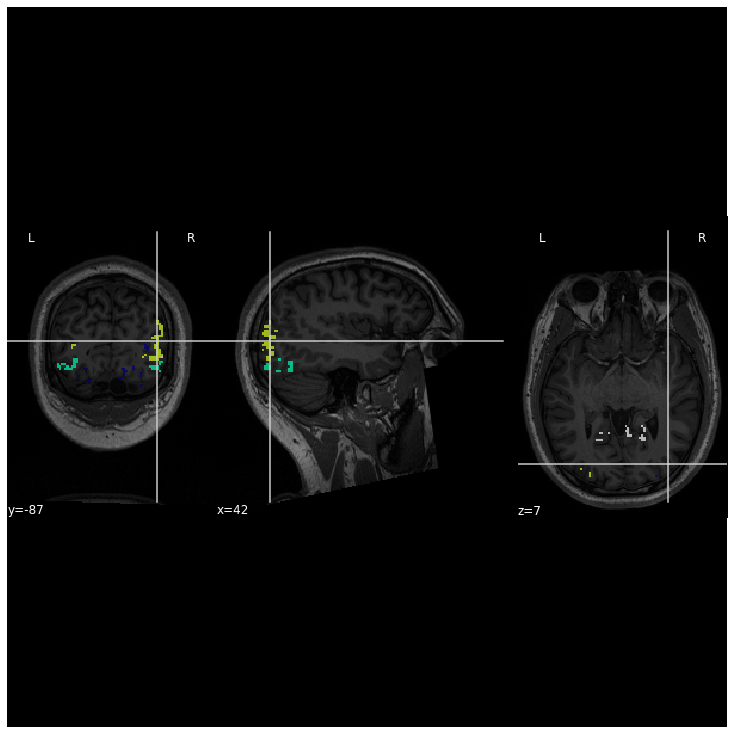

In [68]:
fig = plt.figure(figsize=(10,10))
plotting.plot_roi(comb_csi1_atlas_img, csi1_anat, figure=fig)

In [ ]:
plotting.view_img(comb_csi1_atlas_img, 
                  bg_img=csi1_anat, 
                  cmap=plt.cm.Set1,
                  symmetric_cmap=False,
                  threshold=0,
                  vmin=1,
                  vmax=5
                 )

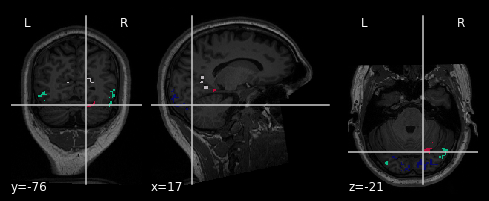

In [75]:
plotting.plot_roi(comb_csi1_atlas_img, csi1_anat, cut_coords=(17, -76, -21))

In [111]:
for mask in masks:
    print(re.search(r'(?<=_mask-LH).*(?=\.nii\.gz$)', str(mask))[0])

EarlyVis
LOC
OPA
PPA
RSC


In [99]:
re.search('(?<=abc)def', 'abcdef').group(0)

'def'

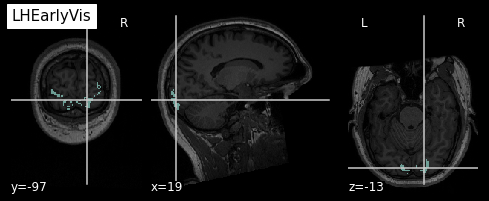

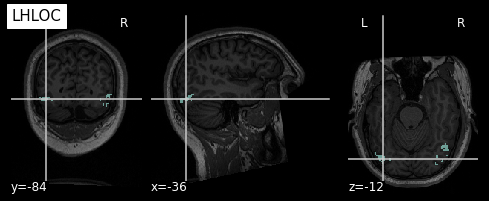

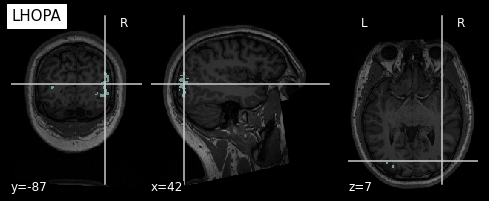

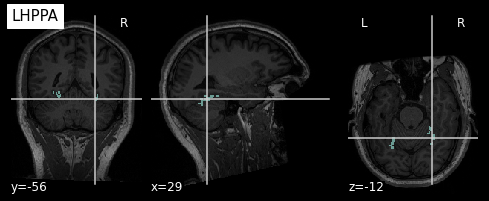

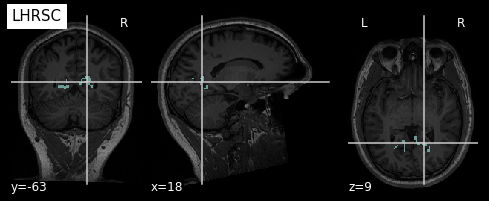

In [114]:
for i, mask in enumerate(csi1_masks[0:]):
    roi = nib.load(mask).get_fdata()
    rh_mask = re.sub(r'(?<=_mask-)L(?=H)', 'R', str(mask))
    roi += nib.load(rh_mask).get_fdata()
    mask_name = re.search(r'(?<=_mask-).*(?=\.nii\.gz$)', str(mask))[0]
    plotting.plot_roi(nib.Nifti1Image(roi, csi1_affine), csi1_anat, cmap=plt.cm.Set3, title=mask_name)